<a href="https://colab.research.google.com/github/phice421/Series-Temporais/blob/main/S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ciência de Dados**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

# Séries Temporais

A seguir temos os principais pontos referente às **séries temporais**:

* Séries temporiais podem ser tratadas em conjuntos de dados que esão relacionados à intervalos de tempo. Iremos estudar o comportamento de uma variável contínua ao longo do tempo.

* O intervalo de tempo entre os dados deve ser regular, isto é, dados coletados mensalmente, diários, minutos, etc. Vale destacar que **não podemos misturar** os intervalos de tempo, isto é, não podemos ter dados coletados em dias em algumas linhas e outros dados coletados em minutos. O intervalo de tempo deve ser o mesmo para todos.

* Temos que ter um único dados por intervalo de tempo. Por exemplo, se você tiver dois dados coletados no dia 01/01/2023, é necessário que você prepare os dados para que se tenha apenas um valor por dia.

* A ordem que os dados foram coletados deve ser mantida, isto é, os dados se você coleta dados diariamente da temperatura de um dado processo, ao salvar esses dados, a ordem dos dias deve estar ordenado nas linhas da sua tabela.

* Usamos as séries temporais para compreender algum objeto de estudo e para fazer previsões sobre o futuro.

## Estudando propriedades de Séries temporais

O conjunto de dados contém as estimativas das vendas mensais de varejo e serviços de alimentação de 1992 a 2020. Essas estimativas são mostradas em milhões de dólares e são baseadas em dados da Pesquisa Mensal de Comércio Varejista, Pesquisa Anual de Comércio Varejista, * Serviço Levantamento Anual e registros administrativos

### Recebendo os dados:

In [2]:
# Recebendo os dados:
from google_drive_downloader import GoogleDriveDownloader as gdd

# Criando uma variável com o id do Arquivo no Google Drive
data_google_id = '1KTroamWPWALdOi1juxUUKYibI9hKJ7cp'

## Fazendo o download do arquivo no Google Drive
gdd.download_file_from_google_drive(file_id=data_google_id, # file_id deve receber o id do seu arquivo no Google Drive
                                    dest_path = './dados_google_drive.csv', # Faz o download dos dados e salva o mesmo num arquivo nomeado dados.csv
                                    showsize = True)
# Carregando o arquivo numa nova variavel:
dados = pd.read_csv("dados_google_drive.csv", sep = ',')


0.0 B Done.


In [3]:
dados.head()

,Period,Value
0,01-01-1992,164095.0
1,01-02-1992,164213.0
2,01-03-1992,163721.0
3,01-04-1992,164709.0
4,01-05-1992,165612.0


### Preparando os dados:

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Period  348 non-null    object 
 1   Value   341 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.6+ KB


Como podemos perceber a coluna de `Period` possui o tipo de `object`. Temos que converter esses dados para `datetime`. Para isso, vamos usar o `pandas.to_datetime()` para converter os dados.

Para isso, devemos passar como argumento a coluna que iremos converter para datetime, no nosso exemplo a coluna `dados['Period']`. Na sequência precisamos informar como o o texto dessa coluna está informando a data. No nosso caso temos dia, mês e ano. Dessa forma, devemos informar na mesma sequência no `format` a configuração das datas: `%d-%m-%Y`

In [5]:
pd.to_datetime(dados['Period'],format='%d-%m-%Y')

0     1992-01-01
1     1992-02-01
2     1992-03-01
3     1992-04-01
4     1992-05-01
         ...    
343   2020-08-01
344   2020-09-01
345   2020-10-01
346   2020-11-01
347   2020-12-01
Name: Period, Length: 348, dtype: datetime64[ns]

Vamos agora ajustar os dados dessa coluna e alterar o índice das linhas para que cada linha tenha o valor de índice com a momento em que o dado foi coletado:

In [6]:
dados['Period'] = pd.to_datetime(dados['Period'],format='%d-%m-%Y')
dados.index = dados['Period']
dados.head()

,Period,Value
Period,,
1992-01-01,1992-01-01,164095.0
1992-02-01,1992-02-01,164213.0
1992-03-01,1992-03-01,163721.0
1992-04-01,1992-04-01,164709.0
1992-05-01,1992-05-01,165612.0


In [7]:
dados.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Period', length=348, freq=None)

Como o índice e a coluna `Period` possuem a mesma informação iremos removê-la dos nossos dados usando o método `drop()`:

In [8]:
dados.drop(columns=['Period'], inplace=True)


In [9]:
dados.head()

,Value
Period,
1992-01-01,164095.0
1992-02-01,164213.0
1992-03-01,163721.0
1992-04-01,164709.0
1992-05-01,165612.0


Checando por valores nulos:

In [10]:
dados.isnull().sum()

Value    7
dtype: int64

In [11]:
dados.dropna(inplace=True)

In [12]:
dados.isnull().sum()

Value    0
dtype: int64

### Fazendo a análise da série temporal

Com os índices das colunas sendo valores do tipo `datetime` podemos criar um `Series` do pandas que possui métodos que serão úteis para a análise de série temporal. Para isso, basta criar uma nova variável recebendo uma única coluna do conjunto de dados:

In [13]:
serie_temporal = dados['Value']
serie_temporal

Period
1992-01-01    164095.0
1992-02-01    164213.0
1992-03-01    163721.0
1992-04-01    164709.0
1992-05-01    165612.0
                ...   
2020-01-01    529616.0
2020-02-01    527273.0
2020-03-01    483949.0
2020-04-01    412766.0
2020-05-01    487708.0
Name: Value, Length: 341, dtype: float64

Podemos acessar os valores das séries temporais a partir do número da linha:

In [14]:
serie_temporal[1]

164213.0

Ou também podemos aproveitar que os índices são datas e informar a data desejada ou intervalo de datas desejadas:

In [15]:
#Visualizando valores pela sua data:
serie_temporal['2008-08-01']

372284.0

In [16]:
#Visualizando por intervalos específicos
serie_temporal['2010-01-01':'2010-12-01']

Period
2010-01-01    346189.0
2010-02-01    346787.0
2010-03-01    354608.0
2010-04-01    357270.0
2010-05-01    354015.0
2010-06-01    354127.0
2010-07-01    354579.0
2010-08-01    356747.0
2010-09-01    359299.0
2010-10-01    363522.0
2010-11-01    367345.0
2010-12-01    369249.0
Name: Value, dtype: float64

In [17]:
#Visualizando por intervalos específicos sem preencher o início
serie_temporal[:'1993-12-01']

Period
1992-01-01    164095.0
1992-02-01    164213.0
1992-03-01    163721.0
1992-04-01    164709.0
1992-05-01    165612.0
1992-06-01    166077.0
1992-07-01    167257.0
1992-08-01    167800.0
1992-09-01    169400.0
1992-10-01    170625.0
1992-11-01    171003.0
1992-12-01    173105.0
1993-01-01    175108.0
1993-02-01    173744.0
1993-03-01    172306.0
1993-04-01    176749.0
1993-05-01    178426.0
1993-06-01    178157.0
1993-07-01    180743.0
1993-08-01    180707.0
1993-09-01    181773.0
1993-10-01    182884.0
1993-11-01    184747.0
1993-12-01    186399.0
Name: Value, dtype: float64

In [18]:
# Selecionando por uma ano específico
serie_temporal['2010']

Period
2010-01-01    346189.0
2010-02-01    346787.0
2010-03-01    354608.0
2010-04-01    357270.0
2010-05-01    354015.0
2010-06-01    354127.0
2010-07-01    354579.0
2010-08-01    356747.0
2010-09-01    359299.0
2010-10-01    363522.0
2010-11-01    367345.0
2010-12-01    369249.0
Name: Value, dtype: float64

Podemos também pesquisar pelos valores mínimos e máximos dos índices. Como isso, podemos verificar o intervalo completo da série temporal:

In [19]:
print(f"Valor mínimo: {serie_temporal.index.min()}\nValor máximo: {serie_temporal.index.max()}")

Valor mínimo: 1992-01-01 00:00:00
Valor máximo: 2020-05-01 00:00:00


Com o `plt.plot()` podemos passar os intervalos das séries temporais e criar gráficos para analisar o comportamento de uma dada variável ao longo do tempo:

* Dados a partir do ano 2000:

Text(0.5, 0, 'Período do ano')

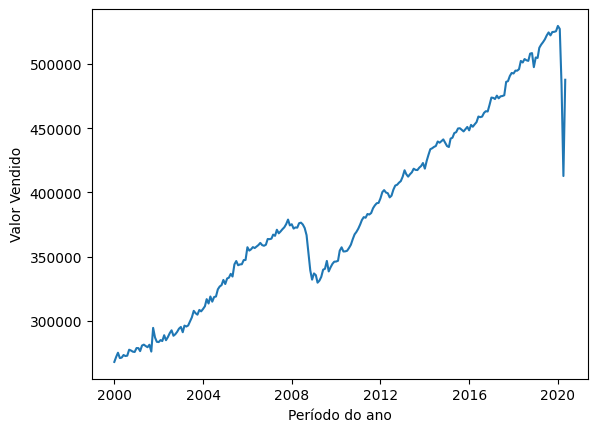

In [20]:
fig = plt.plot()
plt.plot(serie_temporal["2000":])
plt.ylabel('Valor Vendido')
plt.xlabel('Período do ano')

* Dados do ano de 2018:

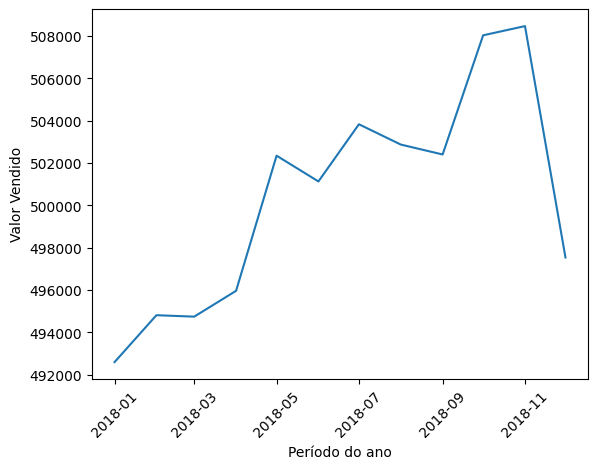

In [21]:
fig = plt.plot()
plt.plot(serie_temporal["2018"])
plt.ylabel('Valor Vendido')
plt.xlabel('Período do ano')
plt.xticks(rotation=45)
plt.show()

Caso houver a necessidade de estudarmos o desempenho por ano, ao invés de meses como estão organizados os dados, podemos usar o método `resample()` e informar como desejamos organizar os nossos dados. Para o intervalo anual podemos usar o argumento `'A'` no `resample()` e obter a soma dos dados em cada ano com o método `sum()`:

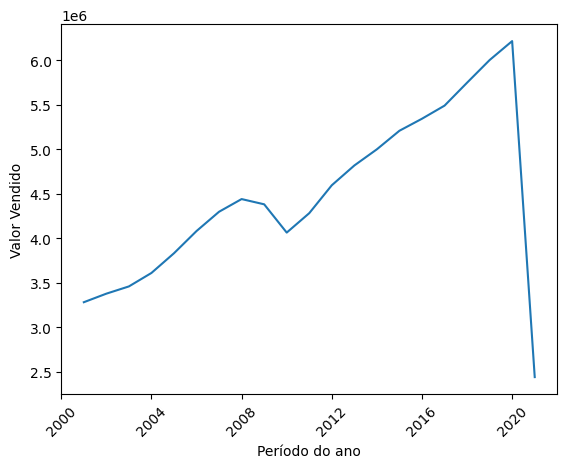

In [22]:
# Visualizando anualmente -> 'A'. 'M' -> por mes
st_ano = serie_temporal.resample('A').sum()
fig = plt.plot()
plt.plot(st_ano["2000":])
plt.ylabel('Valor Vendido')
plt.xlabel('Período do ano')
plt.xticks(rotation=45)
plt.show()

## Decomposição

Em uma série temporal podemos decompor os dados em três grupos: **sazonalidade**, **tendência** e **resíduos**:

* sazonalidade: O efeito da sazonalidade é um comportamento sazonal que ocorre nos dados. Por exemplo, vendas de tickets em um parque de diversão acentuadas em meses de férias escolares

* tendência: tendência dos dados crescerem ou reduzirem;

* resíduos: Valores aleatórios que foram obtidos dos dados

Para decompor os dados da nossa série temporal nessas três componentes iremos usar a classe `seasonal_decompose()`. Como argumento basta informa a variável com a série temporal de interesse:

In [23]:
decomposicao = seasonal_decompose(serie_temporal)

Com os atributos `trend`, `seasonal` e `resid` podemos obter a decomposição de cada ponto nessas três componetes:

In [24]:
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
residuo = decomposicao.resid

Por fim, podemos plotar um gráfico para fazer a análise de cada componente:

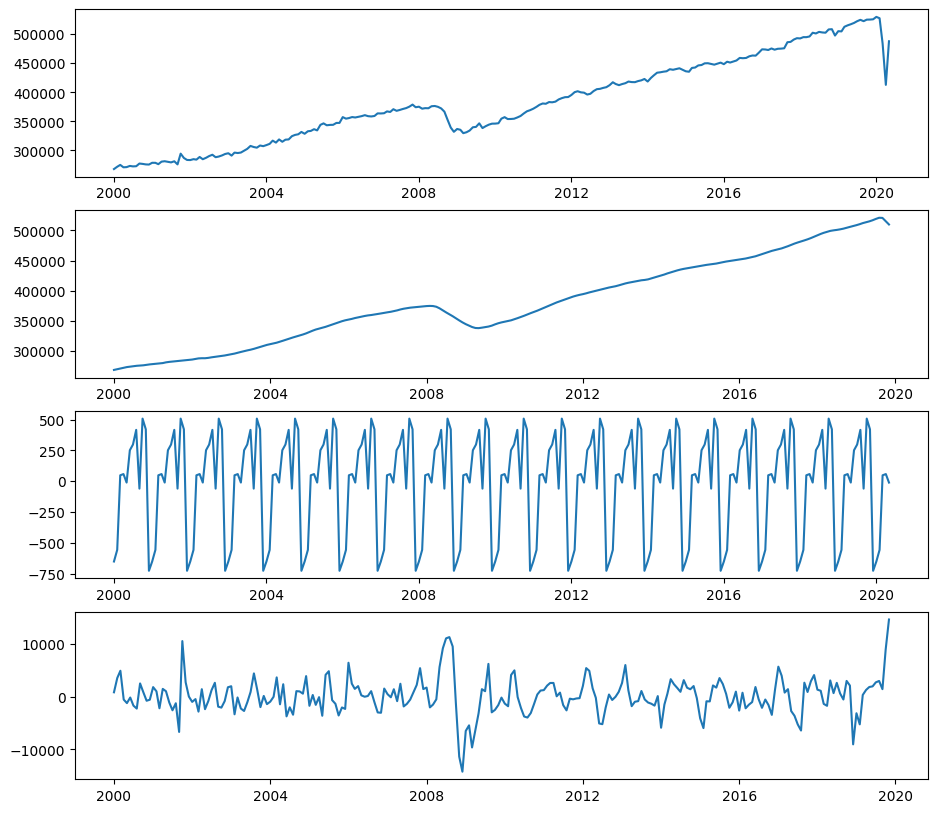

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(11, 10))
axes[0].plot(serie_temporal["2000":])
axes[1].plot(tendencia["2000":])
axes[2].plot(sazonal["2000":])
axes[3].plot(residuo["2000":])

Podemos notar que existe uma tendência dos dados crescerem ao longo do tempo e que houve uma queda significativa nesse crescimento em 2008, indicando alguma crise momentânea do mercado.

Podemos notar também que temos um comportamento sazonal nos nossos dados, que se repetem todos os anos. Vamos analisar esse comportamento focando em apenas uma ano:

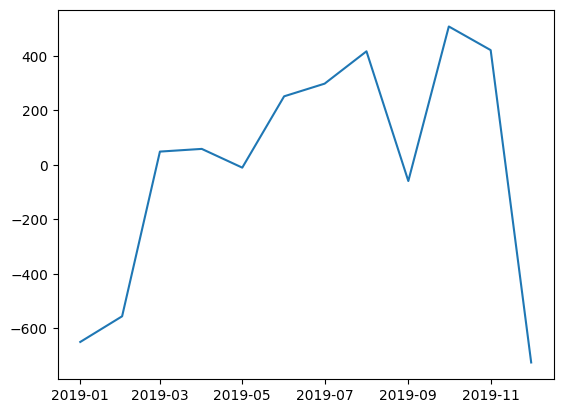

In [26]:
plt.plot(sazonal["2019"])

Podemos notar que no início e no final do ano (de dezembro até fevereiro) temos uma grande baixa nas vendas e outros três picos de vendas: agosto, outubro e novembro.

# Exercício

O exercício é de um conjunto de dados de venda de abacates. O conjunto de dados possui as seguintes colunas:

* **Date**: A data da observação
* **AveragePrice**: o preço médio de um único abacate
* **Total Volume**: Número total de abacates vendidos
* **4046**: Número total de abacates com código de barras 4046 vendidos
* **4225**: Número total de abacates com código de barras 4225 vendidos
* **4770**: Número total de abacates com código de barras 4770 vendidos
* **type**: convencional ou organico
* **year**: ano da coleta do dado
* **region**: a cidade ou região da observação

### 1. Recebendo os dados:

Receba os dados e visualize as colunas do seu conjunto de dados:

In [27]:
# Recebendo os dados:
from google_drive_downloader import GoogleDriveDownloader as gdd

# Criando uma variável com o id do Arquivo no Google Drive
data_google_id = '1KWQj1yc4pPew5h8WeUxCd0IL5xMeqFBh'

## Fazendo o download do arquivo no Google Drive
gdd.download_file_from_google_drive(file_id=data_google_id, # file_id deve receber o id do seu arquivo no Google Drive
                                    dest_path = './dados_exercicio.csv', # Faz o download dos dados e salva o mesmo num arquivo nomeado dados.csv
                                    showsize = True)
# Carregando o arquivo numa nova variavel:
dados_exercicio = pd.read_csv("dados_exercicio.csv", sep = ',')


1.9 MiB Done.


In [28]:
dados_exercicio.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


###2. Preparando os dados:

Verifique os tipos de dados das colunas e mude o tipo da coluna com as datas para o formato `datetime`. Após isso, mude o índice das colunas para que elas possuam os valores das datas da coleta de cada dado.

In [29]:
dados_exercicio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [30]:
pd.to_datetime(dados_exercicio['Date'],format='%Y-%m-%d')

0       2015-12-27
1       2015-12-20
2       2015-12-13
3       2015-12-06
4       2015-11-29
           ...    
18244   2018-02-04
18245   2018-01-28
18246   2018-01-21
18247   2018-01-14
18248   2018-01-07
Name: Date, Length: 18249, dtype: datetime64[ns]

In [31]:
dados_exercicio['Date'] = pd.to_datetime(dados_exercicio['Date'],format='%Y-%m-%d')
dados_exercicio.index = dados_exercicio['Date']
dados_exercicio.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,,
2015-12-27,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [32]:
dados_exercicio.index

DatetimeIndex(['2015-12-27', '2015-12-20', '2015-12-13', '2015-12-06',
               '2015-11-29', '2015-11-22', '2015-11-15', '2015-11-08',
               '2015-11-01', '2015-10-25',
               ...
               '2018-03-11', '2018-03-04', '2018-02-25', '2018-02-18',
               '2018-02-11', '2018-02-04', '2018-01-28', '2018-01-21',
               '2018-01-14', '2018-01-07'],
              dtype='datetime64[ns]', name='Date', length=18249, freq=None)

Verificar os valores únicos das colunas categóricas de `region` e `type`:

In [33]:
dados_exercicio['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [34]:
dados_exercicio['type'].unique()

array(['conventional', 'organic'], dtype=object)

Remover as colunas: 'Unnamed: 0', 'Date', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'

In [35]:
dados_exercicio.drop(columns=['Unnamed: 0', 'Date', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'], inplace=True)

In [36]:
dados_exercicio.head()

,AveragePrice,Total Volume,4046,4225,4770,type,year,region
Date,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,conventional,2015,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,conventional,2015,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,conventional,2015,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,conventional,2015,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,conventional,2015,Albany


Checando por valores nulos:

In [37]:
dados_exercicio.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
type            0
year            0
region          0
dtype: int64

###3. Fazendo a análise da série temporal

Verificar o valor minimo e máximo das datas do seu conjunto de dados:

In [38]:
print(f"Valor mínimo: {serie_temporal.index.min()}\nValor máximo: {serie_temporal.index.max()}")

Valor mínimo: 1992-01-01 00:00:00
Valor máximo: 2020-05-01 00:00:00


O conjunto de dados foi coletado para cada região e para cada tipo de abacate. Logo temos diversas datas que aparecem diversas vezes no nosso conjunto de dados. Por isso, nossa análise deverá ser feita em regioes específicas e com um tipo específico de abacate.

Crie um Series do Pandas para a análise de série temporal para a região de NewYork e para o tipo convencional de abacate.

**Obs.:** Após criar a variável de serie_temporal é necessário ordenar os dados pelo seu índice (`serie_temporal = serie_temporal.sort.index()`). Isso é necessário porque as linhas não estavam ordenadas corretamente!

In [39]:
mask = (dados_exercicio['region']=='NewYork') & (dados_exercicio['type']=='conventional')
serie_temporal = dados_exercicio[mask]['Total Volume']
serie_temporal = serie_temporal.sort_index()

Plotar o gráfico da sua análise temporal para o cenário exposto

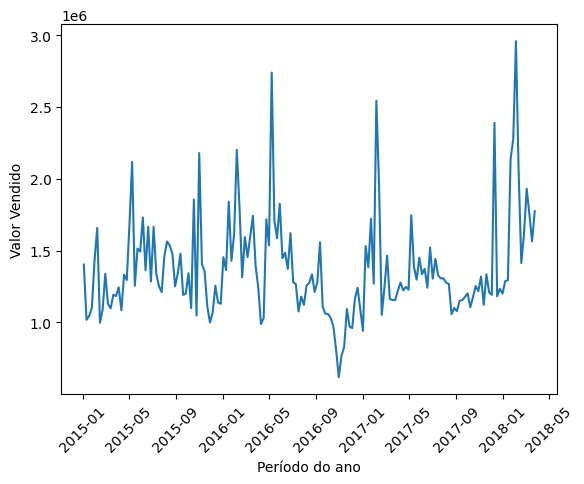

In [40]:
fig = plt.plot()
plt.plot(serie_temporal)
plt.ylabel('Valor Vendido')
plt.xlabel('Período do ano')
plt.xticks(rotation=45)
plt.show()

##4. Decomposição

Faça a decomposição da série temporal do exercício anterior. Após isso, responda:

Existe alguma sazonalidade para a venda de abacate em Nova York?

In [41]:
decomposicao = seasonal_decompose(serie_temporal)

In [42]:
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
residuo = decomposicao.resid

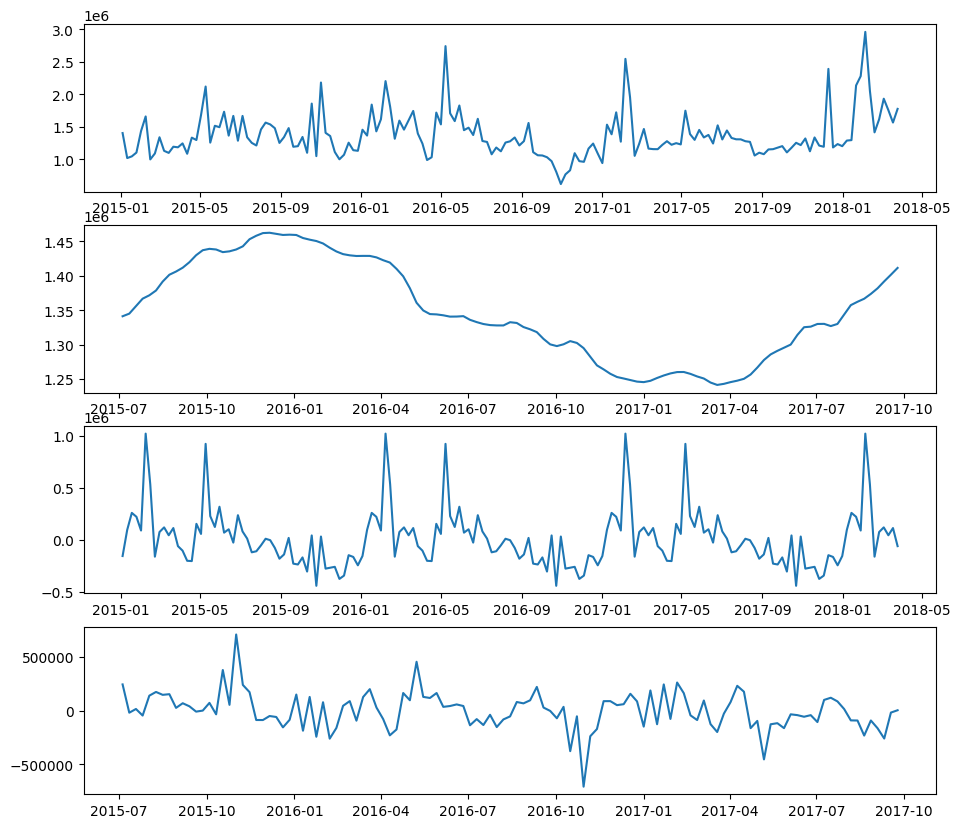

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(11, 10))
axes[0].plot(serie_temporal)
axes[1].plot(tendencia)
axes[2].plot(sazonal)
axes[3].plot(residuo)

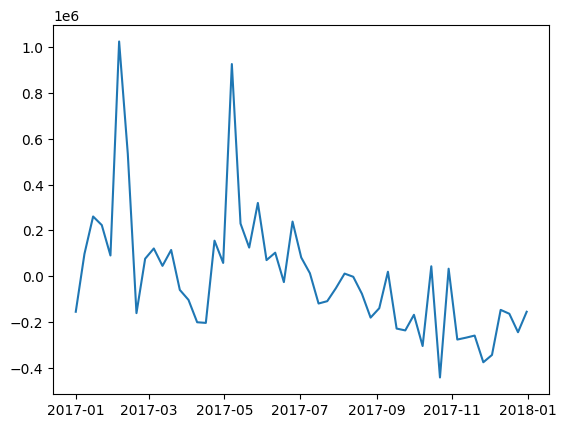

In [44]:
plt.plot(sazonal["2017"])